# Overview
In the following example we will walk through how we can leverage the `clouddrift` library to do something interesting with the HURDAT2 dataset. Simply put, the HURDAT2 dataset is a dataset that contains storm track data (including other measurements such as pressure, wind speed, etc...) for storms recorded from 1852 - 2022 across both the pacific and atlantic ocean.

To get things in motion lets import the `adapters` module from clouddrift and load the dataset into the `ds` variable


We convert the ragged array into an xarray `Dataset` to leverage some of the powerful 
subsetting utilities provided by the data structure that helps power the `subset` function.

In [2]:
import clouddrift
ds = clouddrift.datasets.hurdat2(decode_times=True)
ds

<xarray.Dataset> Size: 13MB
Dimensions:                          (traj: 3143, obs: 84188)
Coordinates:
    id                               (traj) int64 25kB ...
    time                             (obs) datetime64[ns] 674kB ...
Dimensions without coordinates: traj, obs
Data variables: (12/23)
    basin                            (traj) <U2 25kB ...
    atcf_identifier                  (traj) <U8 101kB ...
    year                             (traj) int64 25kB ...
    rowsize                          (traj) int64 25kB ...
    record_identifier                (obs) <U1 337kB ...
    system_status                    (obs) <U2 674kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 674kB ...
    max_high_wind_radius_ne          (obs) float64 674kB ...
    max_high_wind_radius_se          (obs) float64 674kB ...
    max_high_wind_radius_sw          (obs) float64 674kB ...
    max_high_wind_radius_nw          (obs) float64 674kB ...
    max_sustained_wind_speed_radius  (obs) float64 674kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-03-24T21:39:49.842599
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

Now lets say that we'd like to select a specific subset of this dataset; we can leverage the `subset` utility function provided through the `ragged` module which contains a library of helpful utility functions for working with the `RaggedArray` data structure.

As an example say you wanted a subset of the dataset for storms whose track lied within the Atlantic Ocean and was tracked between August and October of 2020. You can leverage the `subset` function by first defining the criteria:

In [3]:
# import some helpful libraries
import numpy as np
from datetime import datetime

# define the critieria
# Here the datasets variables are mapped to an (inclusive start and end) range
criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        np.datetime64(int(datetime(2020, 8, 1).timestamp()), "s"),
        np.datetime64(int(datetime(2020, 10, 1).timestamp()), "s")
    )
)

Lets import the function and apply the criteria to the dataset. 

Here we need to provide the row dimensions alias which is `traj` in the hurdat2 dataset.

In [4]:
from clouddrift.ragged import subset

subset_ds = subset(ds, criteria, row_dim_name="traj")
subset_ds

<xarray.Dataset> Size: 50kB
Dimensions:                          (traj: 14, obs: 313)
Coordinates:
    id                               (traj) int64 112B 3034 3035 ... 3055 3056
    time                             (obs) datetime64[ns] 3kB 2020-08-01T06:0...
Dimensions without coordinates: traj, obs
Data variables: (12/23)
    basin                            (traj) <U2 112B ...
    atcf_identifier                  (traj) <U8 448B ...
    year                             (traj) int64 112B ...
    rowsize                          (traj) int64 112B 19 4 24 7 ... 48 24 7 17
    record_identifier                (obs) <U1 1kB ...
    system_status                    (obs) <U2 3kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 3kB ...
    max_high_wind_radius_ne          (obs) float64 3kB ...
    max_high_wind_radius_se          (obs) float64 3kB ...
    max_high_wind_radius_sw          (obs) float64 3kB ...
    max_high_wind_radius_nw          (obs) float64 3kB ...
    max_sustained_wind_speed_radius  (obs) float64 3kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-03-24T21:39:49.842599
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [9]:
# Lets generate an array identifying the start and end index of each trajectories segment on the RaggedArray 
obs_ranges = np.cumsum(np.array([0, *subset_ds["rowsize"]]))
obs_ranges

array([  0,  19,  23,  47,  54,  77, 103, 106, 135, 215, 217, 265, 289,
       296, 313])

In [8]:
# ids that match the criteria
traj_ids = subset_ds["id"].to_numpy().tolist()
traj_ids

[3034,
 3035,
 3037,
 3039,
 3042,
 3046,
 3047,
 3049,
 3050,
 3051,
 3052,
 3054,
 3055,
 3056]

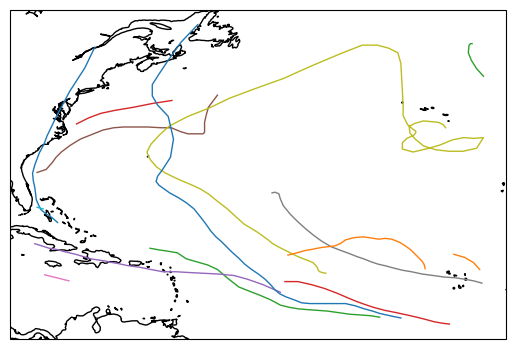

In [7]:
import cartopy.crs as ccrs  # cartopy for projecting our dataset onto different map projections
import matplotlib.pyplot as plt # is an standard plotting library

# Lets display the coastline
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Select the trajectories segments on the longitude and latitude variables and plot them!
for idx, traj_id in enumerate(traj_ids):
    start, end = obs_ranges[idx], obs_ranges[idx+1] # the end is determines by the start of the next index
    selected = slice(start, end) # create a slice to be used for selecting segments of a variable
    plt.plot(subset_ds["lon"].isel(obs=selected), subset_ds["lat"].isel(obs=selected),
        linestyle="-", linewidth=1,
        transform=ccrs.Geodetic()
    )